### **Model 2 with featuring engineering and preprocessing**

In this version, we will apply featuring engineering and preprocessing in the pycare pypeline to see if the model shows some improvements.

**Key featuring engineering:

- Standardize the features
- Remove collinearity

In [1]:
# importing main libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycaret
from pycaret.regression import *

In [2]:
# get the dataframe with media channel spend and sales data

df = pd.read_csv('mediamix_sales.csv')

In [3]:
# Let's view the first 5 rows
df.head()

,Time,tv_sponsorships,tv_cricket,tv_RON,radio,NPP,Magazines,OOH,Social,Programmatic,Display_Rest,Search,Native,sales
0,1/1/01,119.652,66.729,43.719,37.8,55.36,13.84,35,41.8782,5,33.50256,26.802048,5,22100
1,1/2/01,23.140,12.905,8.455,39.3,36.08,9.02,35,8.0990,5,6.47920,5.183360,6,10400
2,1/3/01,8.944,4.988,3.268,45.9,55.44,13.86,35,3.1304,5,2.50432,2.003456,7,9300
3,1/4/01,78.780,43.935,28.785,41.3,46.80,11.70,35,27.5730,5,22.05840,17.646720,5,18500
4,1/5/01,94.016,52.432,34.352,10.8,46.72,11.68,35,32.9056,5,26.32448,21.059584,7,12900


In [4]:
# Now we transfrom the Time column into datetime object

df['Time'] = pd.to_datetime(df['Time'])

In [5]:
df['Time'].dtypes

dtype('<M8[ns]')

### Prepare the dataset for the model building

- Preparing the unseen data dropping the 20% of the rows and save them as a csv file for the model prediction in streamlit

In [6]:
# sample the last 10 rows of a dataframe and save it as a csv file
#df.tail(10).to_csv('unseen_data.csv') we have already the unseen data and here we use the saturated spend transformed unseen data

# drop the last 10 rows of a dataframe and create a new dataframe
df_train_data = df.drop(df.tail(10).index)

In [7]:
df_train_data.shape

(190, 14)

### Apply saturation transformation to media channels

**Saturation Effect or Diminishing Return**

Increasing the amount of advertising increases the percent of the audience reached by the advertising, hence increases demand, but a linear increase in the advertising exposure doesn’t have a similar linear effect on demand.

Typically each incremental amount of advertising causes a progressively lesser effect on demand increase.
This is advertising saturation. Saturation only occurs above a threshold level that can be determined by Adstock Analysis.
Usually Digital display ads and digital advertising in general have a high saturation effect, meanwhile TV, Radio have a low saturation effect.

#### Next steps

- Implement the saturation before implementing pycaret pipeline 
- Build the model (this time with featuring engineering and preprocessing in Pycaret)

##### Implementing the saturation before the pycaret pipeline



In [8]:
# Saturation or diminishing return function

def logistic_function(x_t, mu):
     '''
     param x_t: marketing spend vector (float)
     param mu: half-saturation point(float)
     return: transformed spend vector
     '''
     return (1 - np.exp(-mu * x_t)) / (1 + np.exp(-mu * x_t)) 

In [9]:
# Apply the saturation function on each column
df_train_data_sat = pd.DataFrame({
    'tv_sponsorships_sat': logistic_function(df_train_data['tv_sponsorships'].values, 0.05),
    'tv_cricket_sat': logistic_function(df_train_data['tv_cricket'].values, 0.05),
    'tv_RON_sat': logistic_function(df_train_data['tv_RON'].values, 0.1),
    'radio_sat': logistic_function(df_train_data['radio'].values, 0.2),
    'NPP_sat': logistic_function(df_train_data['NPP'].values, 0.5),
    'Magazines_sat': logistic_function(df_train_data['Magazines'].values, 0.4),
    'OOH_sat': logistic_function(df_train_data['OOH'].values, 0.3),
    'Social_sat': logistic_function(df_train_data['Social'].values, 0.7),
    'Programmatic_sat': logistic_function(df_train_data['Programmatic'].values, 0.8),
    'Display_Rest_sat': logistic_function(df_train_data['Display_Rest'].values, 0.7),
    'Search_sat': logistic_function(df_train_data['Search'].values, 0.6),
    'Native_sat': logistic_function(df_train_data['Native'].values, 0.9),
    'sales': df_train_data['sales']
    
})

In [10]:
# show the newly created dataframe with the saturated spend and sales

df_train_data_sat.head(10)

,tv_sponsorships_sat,tv_cricket_sat,tv_RON_sat,radio_sat,NPP_sat,Magazines_sat,OOH_sat,Social_sat,Programmatic_sat,Display_Rest_sat,Search_sat,Native_sat,sales
0,0.994968,0.931317,0.975060,0.998959,1.000000,0.992146,0.999945,1.000000,0.964028,1.000000,1.000000,0.978026,22100
1,0.521574,0.311879,0.399245,0.999229,1.000000,0.947219,0.999945,0.993123,0.964028,0.978783,0.914608,0.991007,10400
2,0.219947,0.124058,0.161961,0.999794,1.000000,0.992209,0.999945,0.798927,0.964028,0.704668,0.537787,0.996334,9300
3,0.961808,0.799915,0.893547,0.999483,1.000000,0.981613,0.999945,1.000000,0.964028,1.000000,0.999950,0.978026,18500
4,0.981988,0.864478,0.937573,0.793199,1.000000,0.981466,0.999945,1.000000,0.964028,1.000000,0.999993,0.996334,12900
5,0.112620,0.062991,0.082462,0.999887,1.000000,0.995055,0.999945,0.503654,0.964028,0.416419,0.294981,0.998508,7200
6,0.633655,0.394295,0.497704,0.997172,0.999835,0.735222,0.999945,0.998684,0.999329,0.994316,0.964677,0.999393,11800
7,0.915841,0.702110,0.815053,0.961090,0.980869,0.433339,0.999945,1.000000,0.999329,0.999990,0.999551,0.978026,13200
8,0.111337,0.062269,0.081519,0.206966,0.197375,0.039979,0.999945,0.498885,0.999329,0.412198,0.291787,0.978026,4800
9,0.988971,0.895406,0.956075,0.254296,0.999585,0.690023,0.999945,1.000000,0.999329,1.000000,0.999998,0.978026,10600


### Building the model with pycaret

We will test the second version of the model, with pre-processing this time.

The preprocessing consists on remove multicollinearity, standardization will make some values of the features negative, and for media mix modelling, spending can never being negative.

##### Test 2 with pre-processing/featuring engineering of the dataset

In [19]:
model_2 = setup(data = df_train_data_sat, target = 'sales', session_id=123, remove_multicollinearity = True,
                multicollinearity_threshold = 0.85
                )

,Description,Value
0,session_id,123
1,Target,sales
2,Original Data,"(190, 13)"
3,Missing Values,False
4,Numeric Features,12
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(132, 11)"


In [21]:
# now compare the top5 best modesl based on R2

top_5 = compare_models(n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1124.5473,2355782.6659,1494.2973,0.8953,0.1111,0.0875,0.0270
lightgbm,Light Gradient Boosting Machine,1161.9622,2856533.5201,1614.8840,0.8449,0.1136,0.0867,0.0060
gbr,Gradient Boosting Regressor,1175.8192,2970285.4687,1623.6791,0.8425,0.1155,0.0884,0.0090
rf,Random Forest Regressor,1397.9786,3712397.8885,1864.8473,0.8348,0.1318,0.1055,0.0320
ada,AdaBoost Regressor,1627.6139,4509168.8178,2092.8243,0.7945,0.1567,0.1294,0.0140
lasso,Lasso Regression,2199.5956,7796115.8118,2719.3816,0.6696,0.2132,0.1631,0.0040
llar,Lasso Least Angle Regression,2211.8957,7843420.6874,2734.2058,0.6666,0.2126,0.1650,0.0030
lr,Linear Regression,2219.1160,7877785.1602,2743.0919,0.6633,0.2155,0.1659,0.0040
lar,Least Angle Regression,2219.1160,7877787.4604,2743.0924,0.6633,0.2155,0.1659,0.0030
br,Bayesian Ridge,2232.1007,7927490.8633,2743.0454,0.6621,0.2128,0.1651,0.0040


#### **Intersting highlights compared to model 1 (without feat engineering)**

Looking at the date below, we can see that although the top5 models are the same, there is a slight improvement in R2 in all of each model2 vs model1:

**Model 1 - No feat eng vs Model2 - with feat eng**

- Extra Trees Regressor R2: **Model1** (0.8884) **Model2** (0.8953)
- Light Gradient Boosting Machine R2: **Model1**(0.84530) **Model2**(0.8449)
- Gradient Boosting Regressor R2: **Model1** (0.8355) **Model2** (0.8425)
- Random Forest Regressor R2: **Model1** (0.8247) **Model2**(0.8348)
- AdaBoost Regressor R2: **Model1** (0.7904) **Model2** (0.7945)  


#### Creating Extra Tree Regressor

For semplicity we are only going to create the Extra Tree Regressor Model and we ll see if fine tuning will improve the performance

In [22]:
# Extra Tree Regressor

e_tree = create_model('et', fold = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1077.2857,1554695.4286,1246.8743,0.9342,0.0968,0.0852
1,1131.5714,2144038.0000,1464.2534,0.9215,0.1199,0.0955
2,953.5385,1303807.6923,1141.8440,0.9484,0.0808,0.0688
3,728.6923,1061969.4615,1030.5190,0.9193,0.0914,0.0662
4,960.3077,2196500.4615,1482.0595,0.8945,0.0947,0.0696
5,1290.1538,3189655.0769,1785.9605,0.8609,0.1378,0.1113
6,1492.6154,3722209.2308,1929.3028,0.9195,0.1799,0.1349
7,1119.7692,2708188.0769,1645.6573,0.7215,0.0943,0.0686
8,940.3846,1223996.0769,1106.3436,0.9586,0.0931,0.0771
9,1551.1538,4452767.1538,2110.1581,0.8749,0.1219,0.0979


In [23]:
# Tune the Extra Tree Model

tuned_e_tree = tune_model(e_tree, round= 2, optimize='R2', n_iter=50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1369.16,2840459.63,1685.37,0.88,0.12,0.11
1,1090.40,1651144.51,1284.97,0.94,0.12,0.10
2,1190.75,2215353.12,1488.41,0.91,0.10,0.09
3,953.92,1366574.92,1169.01,0.90,0.11,0.09
4,1355.88,3538467.29,1881.08,0.83,0.13,0.11
5,1543.39,4906387.84,2215.04,0.79,0.18,0.14
6,2021.03,6398304.33,2529.49,0.86,0.21,0.17
7,1195.45,2809497.50,1676.16,0.71,0.09,0.07
8,1168.66,1897497.21,1377.50,0.94,0.12,0.10
9,1751.21,6511820.14,2551.83,0.82,0.13,0.10


As model1 finetuning will actually decrease the R2 level therefore we keep the original model and we start the production

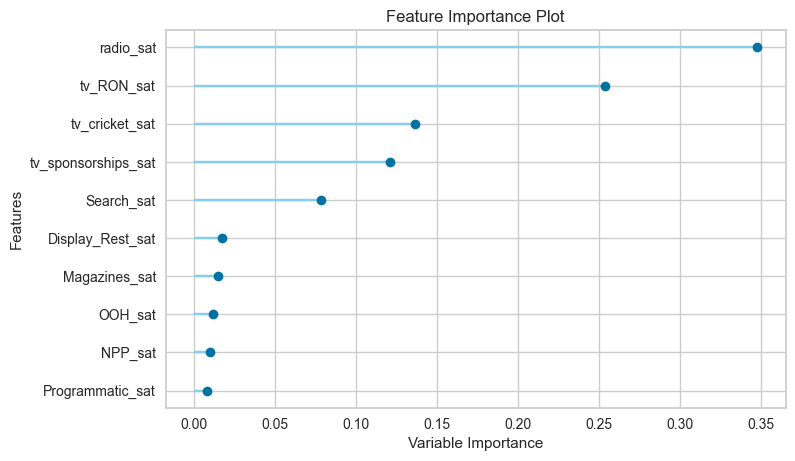

In [24]:
# Extra Tree Feature Importance
plot_model(e_tree, plot = 'feature')

#### Predict on Test / Hold-out Sample
##### Extra Tree Regressor


In [25]:
predict_model(e_tree)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1163.1552,2266617.2241,1505.5289,0.9086,0.2132,0.1413


,tv_sponsorships_sat,tv_cricket_sat,tv_RON_sat,radio_sat,NPP_sat,Magazines_sat,OOH_sat,Programmatic_sat,Display_Rest_sat,Search_sat,Native_sat,sales,Label
0,0.906271,0.049958,0.995177,0.993330,0.996649,0.276603,0.999753,1.000000,0.999985,0.999392,0.978026,14200,15962.0
1,0.244919,0.945363,0.999995,0.994314,0.987136,0.465257,0.999988,0.999329,0.336376,1.000000,0.978026,15000,18801.0
2,0.943609,0.976335,0.708915,0.997492,1.000000,0.649249,0.999988,1.000000,0.999998,0.999853,0.978026,17100,19284.0
3,0.981988,0.864478,0.937573,0.793199,1.000000,0.981466,0.999945,0.964028,1.000000,0.999994,0.996334,12900,13233.0
4,0.997986,0.024995,0.938462,0.947832,0.999991,0.841998,0.978026,1.000000,1.000000,1.000000,0.978026,14400,14732.0
5,0.899195,0.024995,0.625506,0.935409,0.988582,0.474607,0.999988,1.000000,0.999980,0.999253,0.978026,10900,11034.0
6,0.932699,0.049958,0.997578,0.454216,0.970012,0.183884,0.999753,1.000000,0.999996,0.999759,0.978026,11200,11564.0
7,0.772702,0.857481,0.472668,0.994644,0.955373,0.166437,0.995055,1.000000,0.999363,0.992029,0.978026,14000,13887.0
8,0.949433,0.979395,0.722569,0.999806,1.000000,0.825550,0.995055,1.000000,0.999999,0.999891,0.978026,21200,22351.0
9,0.193047,0.878350,0.653853,0.999828,0.999998,0.880951,0.999988,1.000000,0.336376,0.481937,0.978026,14600,12900.0


##### Final Model Selected: Extra Tree Regressor

In [27]:
# Finalize Model for Deployment

final_e_tree = finalize_model(e_tree)

In [28]:
print(final_e_tree)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)


In [29]:
predict_model(final_e_tree)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


,tv_sponsorships_sat,tv_cricket_sat,tv_RON_sat,radio_sat,NPP_sat,Magazines_sat,OOH_sat,Programmatic_sat,Display_Rest_sat,Search_sat,Native_sat,sales,Label
0,0.906271,0.049958,0.995177,0.993330,0.996649,0.276603,0.999753,1.000000,0.999985,0.999392,0.978026,14200,14200.0
1,0.244919,0.945363,0.999995,0.994314,0.987136,0.465257,0.999988,0.999329,0.336376,1.000000,0.978026,15000,15000.0
2,0.943609,0.976335,0.708915,0.997492,1.000000,0.649249,0.999988,1.000000,0.999998,0.999853,0.978026,17100,17100.0
3,0.981988,0.864478,0.937573,0.793199,1.000000,0.981466,0.999945,0.964028,1.000000,0.999994,0.996334,12900,12900.0
4,0.997986,0.024995,0.938462,0.947832,0.999991,0.841998,0.978026,1.000000,1.000000,1.000000,0.978026,14400,14400.0
5,0.899195,0.024995,0.625506,0.935409,0.988582,0.474607,0.999988,1.000000,0.999980,0.999253,0.978026,10900,10900.0
6,0.932699,0.049958,0.997578,0.454216,0.970012,0.183884,0.999753,1.000000,0.999996,0.999759,0.978026,11200,11200.0
7,0.772702,0.857481,0.472668,0.994644,0.955373,0.166437,0.995055,1.000000,0.999363,0.992029,0.978026,14000,14000.0
8,0.949433,0.979395,0.722569,0.999806,1.000000,0.825550,0.995055,1.000000,0.999999,0.999891,0.978026,21200,21200.0
9,0.193047,0.878350,0.653853,0.999828,0.999998,0.880951,0.999988,1.000000,0.336376,0.481937,0.978026,14600,14600.0


#### Predict the model on unseen data saturated spend file: unseen_data_df_sat.csv

In [31]:
# Import the unseen data csv file
unseen_data_df_sat = pd.read_csv('unseen_data_df_sat.csv')

In [32]:
unseen_data_df_sat.head()

,Unnamed: 0,tv_sponsorships_sat,tv_cricket_sat,tv_RON_sat,radio_sat,NPP_sat,Magazines_sat,OOH_sat,Social_sat,Programmatic_sat,Display_Rest_sat,Search_sat,Native_sat,sales
0,0,0.241979,0.241979,0.756294,0.999462,0.986614,0.197375,0.978026,0.836586,1.0,0.747714,0.580754,0.978026,10800
1,1,0.439713,0.439713,0.955154,0.793199,0.986614,0.197375,0.978026,0.980571,1.0,0.951722,0.853363,0.978026,9900
2,2,0.107088,0.107088,0.405321,0.388473,0.986614,0.197375,0.978026,0.482893,1.0,0.398109,0.281177,0.978026,5900
3,3,0.778873,0.778873,0.999523,0.999550,0.986614,0.197375,0.978026,0.999927,1.0,0.999436,0.992664,0.978026,19600
4,4,0.733206,0.733206,0.998878,0.998384,0.986614,0.197375,0.978026,0.999792,1.0,0.998697,0.987006,0.978026,17300


In [33]:
# Implementation of Extra Tree Regression Model on unseen saturated spend

unseen_predictions = predict_model(final_e_tree, data=unseen_data_df_sat)
unseen_predictions.head()

,Unnamed: 0,tv_sponsorships_sat,tv_cricket_sat,tv_RON_sat,radio_sat,NPP_sat,Magazines_sat,OOH_sat,Social_sat,Programmatic_sat,Display_Rest_sat,Search_sat,Native_sat,sales,Label
0,0,0.241979,0.241979,0.756294,0.999462,0.986614,0.197375,0.978026,0.836586,1.0,0.747714,0.580754,0.978026,10800,10331.0
1,1,0.439713,0.439713,0.955154,0.793199,0.986614,0.197375,0.978026,0.980571,1.0,0.951722,0.853363,0.978026,9900,10445.0
2,2,0.107088,0.107088,0.405321,0.388473,0.986614,0.197375,0.978026,0.482893,1.0,0.398109,0.281177,0.978026,5900,6207.0
3,3,0.778873,0.778873,0.999523,0.999550,0.986614,0.197375,0.978026,0.999927,1.0,0.999436,0.992664,0.978026,19600,18993.0
4,4,0.733206,0.733206,0.998878,0.998384,0.986614,0.197375,0.978026,0.999792,1.0,0.998697,0.987006,0.978026,17300,16798.0


In [34]:
# Check metrics on unseen data

from pycaret.utils import check_metric
check_metric(unseen_predictions.sales, unseen_predictions.Label, 'R2')

0.9919

### Difference Model1 vs Model2

Interesting to note that the R2 on unseendata predictions for Model2(feat eng model) is 0.9919 and for Model1(non feat eng) is 0.9881. A slight but interesting increase in performance after removing multicollinearity

<AxesSubplot:>

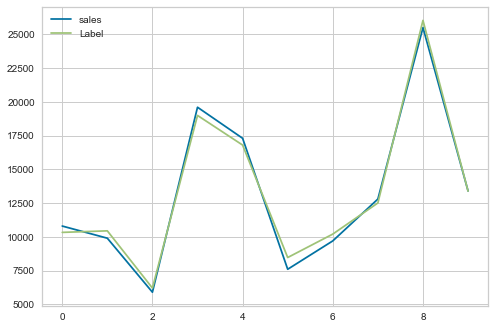

In [35]:
# Let's plot the sales data vs predicted of the unseen dataframe

unseen_predictions.sales.plot(legend=True)
unseen_predictions.Label.plot(legend=True)

#### Save Model2

In [36]:
save_model(final_e_tree,'Final ExtraTreeRegr_feateng_preproc Model2 20Dic2021')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='sales',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='...
                  ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                      criterion='mse', max_depth=None,
                                      max_features='auto', max_leaf_nodes=None,
                                      max_samples=None,
                                    